## cálculo de umbrales óptimos y evaluación

1. Cargando modelo y tokenizador...
   - Usando dispositivo: cpu
   - ¡Modelo y tokenizador cargados exitosamente!

2. Cargando conjuntos de datos de validación y prueba...

   - Tokenizando 357 muestras...
   - Realizando inferencia...


c:\Users\samue\anaconda3\envs\deepxde_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



3. Buscando umbrales óptimos en el conjunto de validación...
   - Umbrales encontrados:
{
  "cardiovascular": 0.1,
  "hepatorenal": 0.39,
  "neurological": 0.77,
  "oncological": 0.84
}

4. Evaluando el modelo en el conjunto de prueba con los umbrales encontrados...

   - Tokenizando 357 muestras...
   - Realizando inferencia...


c:\Users\samue\anaconda3\envs\deepxde_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 REPORTE DE CLASIFICACIÓN POR CLASE (CON UMBRALES ÓPTIMOS)
                precision    recall  f1-score   support

cardiovascular       0.98      0.96      0.97       127
   hepatorenal       0.97      0.96      0.97       110
  neurological       0.94      0.95      0.95       179
   oncological       0.94      0.98      0.96        61

     micro avg       0.96      0.96      0.96       477
     macro avg       0.96      0.96      0.96       477
  weighted avg       0.96      0.96      0.96       477
   samples avg       0.97      0.98      0.97       477


🌍 MÉTRICAS GLOBALES (CON UMBRALES ÓPTIMOS)
   - F1-Score (Micro):    0.9592
   - F1-Score (Macro):    0.9608
   - F1-Score (Weighted): 0.9592  <-- Métrica principal
   - Subset Accuracy:     0.9020

🌀 MATRICES DE CONFUSIÓN POR CLASE


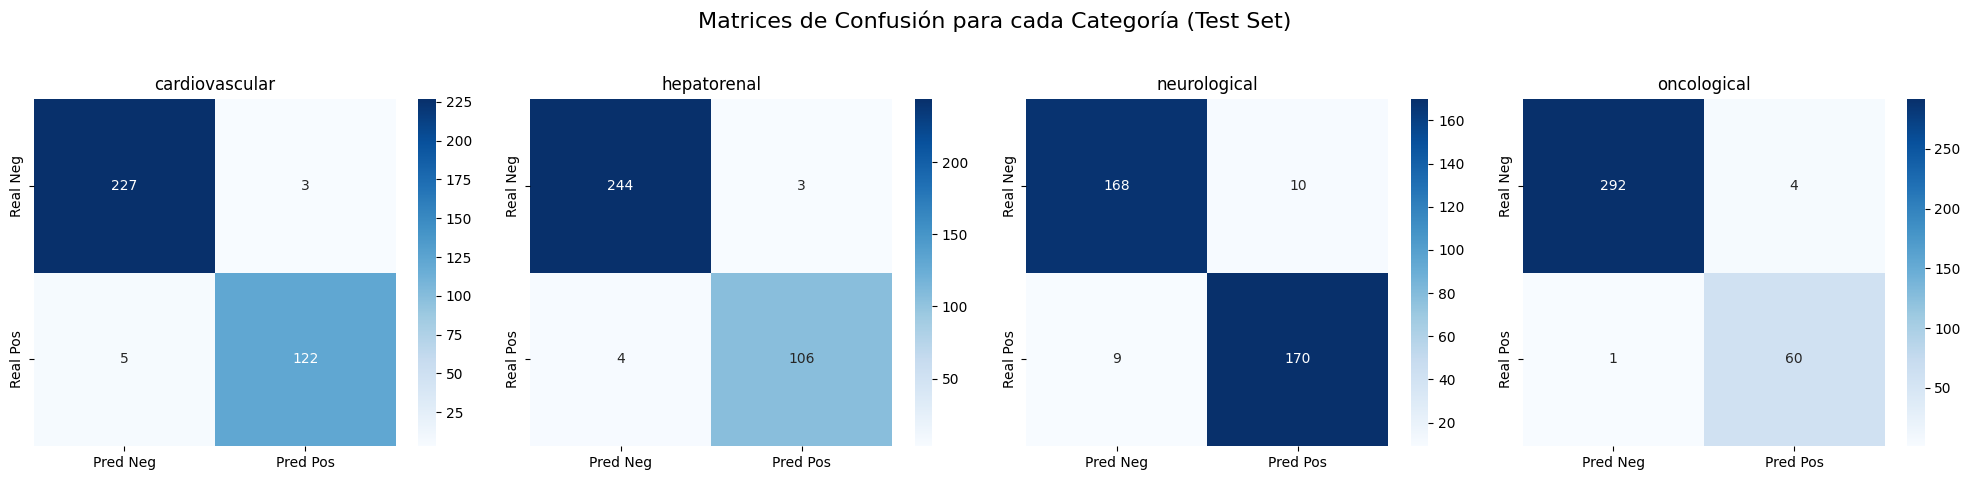


5. Guardando las predicciones finales en 'database/test_predictions_with_optimal_thresholds.csv'...

🎉 ¡Proceso completado exitosamente!


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import json

# ==============================================================================
# ⚙️ PASO 1: CONFIGURACIÓN
# Define las rutas y los parámetros clave.
# ==============================================================================
MODEL_PATH = "models/scibert_uncased/"
# !!! AÑADE LA RUTA A TU CONJUNTO DE VALIDACIÓN !!!
VALIDATION_DATA_PATH = "data\processed\val_set.csv" 
TEST_DATA_PATH = "data\processed\test_set.csv"
OUTPUT_PREDICTIONS_PATH = "data\processed\test_predictions_with_optimal_thresholds.csv"

# El nombre de la columna que contiene el texto (título + resumen)
TEXT_COLUMN = 'text' 
# La lista de columnas que son tus etiquetas/categorías
LABEL_COLUMNS = ['cardiovascular','hepatorenal','neurological', 'oncological']

# ==============================================================================
# 💾 PASO 2: CARGAR MODELO Y TOKENIZADOR
# Esto solo se hace una vez para ahorrar memoria.
# ==============================================================================
print("1. Cargando modelo y tokenizador...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   - Usando dispositivo: {device}")

try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    print("   - ¡Modelo y tokenizador cargados exitosamente!")
except OSError:
    print(f"Error: No se encontró el modelo en la ruta '{MODEL_PATH}'. Asegúrate de que la ruta sea correcta.")
    exit()


# ==============================================================================
# 헬 FUNCIÓN 1: OBTENER PREDICCIONES DE UN DATAFRAME (VERSIÓN CORREGIDA)
# Encapsula la lógica de tokenización e inferencia para poder reutilizarla.
# ==============================================================================

# Primero, define una clase Dataset que devuelva diccionarios
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Devuelve un diccionario para cada muestra
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def obtener_predicciones(df, text_col, label_cols):
    """Tokeniza un DataFrame y devuelve las probabilidades y etiquetas verdaderas."""
    print(f"\n   - Tokenizando {len(df)} muestras...")
    # Tokeniza toda la lista de textos a la vez
    encodings = tokenizer(df[text_col].tolist(), truncation=True, padding=True, max_length=512)
    
    # Usa la clase de Dataset personalizada
    dataset = InferenceDataset(encodings)
    
    args = TrainingArguments(
        output_dir='./temp_results',
        per_device_eval_batch_size=16,
        do_predict=True,
        fp16=torch.cuda.is_available(),
        report_to="none", # Evita warnings de W&B
    )
    
    trainer = Trainer(model=model, args=args)
    
    print(f"   - Realizando inferencia...")
    raw_predictions = trainer.predict(dataset)
    
    # Convertir logits a probabilidades
    logits = raw_predictions.predictions
    probabilities = 1 / (1 + np.exp(-logits)) # Función Sigmoide
    
    true_labels = df[label_cols].values if all(col in df.columns for col in label_cols) else None
    
    return probabilities, true_labels




# ==============================================================================
# 🎯 FUNCIÓN 2: ENCONTRAR UMBRALES ÓPTIMOS
# Usa el conjunto de validación para encontrar el mejor umbral por clase.
# ==============================================================================
def encontrar_umbrales_optimos(y_true, y_pred_probs, class_names):
    """Encuentra los umbrales óptimos por clase para maximizar el F1-score."""
    print("\n3. Buscando umbrales óptimos en el conjunto de validación...")
    umbrales_optimos = {}
    for i, name in enumerate(class_names):
        mejor_f1 = 0.0
        mejor_umbral = 0.5
        for umbral in np.arange(0.1, 0.91, 0.01):
            preds = (y_pred_probs[:, i] >= umbral).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > mejor_f1:
                mejor_f1 = f1
                mejor_umbral = umbral
        umbrales_optimos[name] = round(mejor_umbral, 2)
    print("   - Umbrales encontrados:")
    print(json.dumps(umbrales_optimos, indent=2))
    return umbrales_optimos

# ==============================================================================
# 📊 FUNCIÓN 3: EVALUAR RENDIMIENTO
# Calcula y muestra todas las métricas usando umbrales específicos.
# ==============================================================================
def evaluar_rendimiento(y_true, y_pred_probs, umbrales, class_names):
    """Calcula y muestra un reporte completo de métricas de clasificación."""
    # Aplicar umbrales optimizados para obtener etiquetas finales
    umbrales_array = np.array([umbrales[name] for name in class_names])
    predicted_labels = (y_pred_probs >= umbrales_array).astype(int)

    print("\n" + "="*50)
    print("📊 REPORTE DE CLASIFICACIÓN POR CLASE (CON UMBRALES ÓPTIMOS)")
    print("="*50)
    print(classification_report(y_true, predicted_labels, target_names=class_names, zero_division=0))

    print("\n" + "="*50)
    print("🌍 MÉTRICAS GLOBALES (CON UMBRALES ÓPTIMOS)")
    print("="*50)
    f1_micro = f1_score(y_true, predicted_labels, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, predicted_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, predicted_labels, average='weighted', zero_division=0)
    subset_accuracy = accuracy_score(y_true, predicted_labels)
    print(f"   - F1-Score (Micro):    {f1_micro:.4f}")
    print(f"   - F1-Score (Macro):    {f1_macro:.4f}")
    print(f"   - F1-Score (Weighted): {f1_weighted:.4f}  <-- Métrica principal")
    print(f"   - Subset Accuracy:     {subset_accuracy:.4f}")

    print("\n" + "="*50)
    print("🌀 MATRICES DE CONFUSIÓN POR CLASE")
    print("="*50)
    conf_matrices = multilabel_confusion_matrix(y_true, predicted_labels)
    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
    fig.suptitle('Matrices de Confusión para cada Categoría (Test Set)', fontsize=16)
    for i, matrix in enumerate(conf_matrices):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Real Neg', 'Real Pos'])
        axes[i].set_title(class_names[i])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return predicted_labels

# ==============================================================================
# 🚀 PASO 3: EJECUCIÓN DEL FLUJO PRINCIPAL
# ==============================================================================

# --- Cargar Datos de Validación y Test ---
print("\n2. Cargando conjuntos de datos de validación y prueba...")
try:
    validation_df = pd.read_csv(VALIDATION_DATA_PATH)
    test_df = pd.read_csv(TEST_DATA_PATH)
    # Limpieza básica
    validation_df.dropna(subset=LABEL_COLUMNS + [TEXT_COLUMN], inplace=True)
    test_df.dropna(subset=LABEL_COLUMNS + [TEXT_COLUMN], inplace=True)
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo de datos: {e.filename}")
    exit()

# --- Etapa de Validación: Encontrar Umbrales ---
val_probs, val_labels = obtener_predicciones(validation_df, TEXT_COLUMN, LABEL_COLUMNS)
umbrales_optimos = encontrar_umbrales_optimos(val_labels, val_probs, LABEL_COLUMNS)

# --- Etapa de Prueba: Evaluación Final ---
print("\n4. Evaluando el modelo en el conjunto de prueba con los umbrales encontrados...")
test_probs, test_labels = obtener_predicciones(test_df, TEXT_COLUMN, LABEL_COLUMNS)
final_predictions = evaluar_rendimiento(test_labels, test_probs, umbrales_optimos, LABEL_COLUMNS)

# ==============================================================================
# 📄 PASO 4: GUARDAR PREDICCIONES FINALES
# ==============================================================================
print(f"\n5. Guardando las predicciones finales en '{OUTPUT_PREDICTIONS_PATH}'...")
predictions_df = pd.DataFrame(final_predictions, columns=[f'{col}_pred' for col in LABEL_COLUMNS])
results_df = pd.concat([test_df.reset_index(drop=True), predictions_df], axis=1)
results_df.to_csv(OUTPUT_PREDICTIONS_PATH, index=False)

print("\n🎉 ¡Proceso completado exitosamente!")

In [3]:
print(umbrales_optimos)

{'cardiovascular': 0.1, 'hepatorenal': 0.39, 'neurological': 0.77, 'oncological': 0.84}


--- METRICAS GLOBALES (PONDERADAS) ---
✅ F1-Score Ponderado: 0.9592
🎯 Precisión Ponderada: 0.9584
📈 Recall Ponderado: 0.9602
💯 Exactitud (Subset Accuracy): 0.9020

--- REPORTE POR CLASE ---


,precision,recall,f1-score,support
cardiovascular,0.976000,0.960630,0.968254,127.0
hepatorenal,0.972477,0.963636,0.968037,110.0
neurological,0.944444,0.949721,0.947075,179.0
oncological,0.937500,0.983607,0.960000,61.0
micro avg,0.958159,0.960168,0.959162,477.0
macro avg,0.957605,0.964398,0.960841,477.0
weighted avg,0.958423,0.960168,0.959201,477.0
samples avg,0.974790,0.976190,0.968627,477.0




--- MATRIZ DE CONFUSIÓN MULTI-ETIQUETA ---

Matriz para la clase: 'cardiovascular'


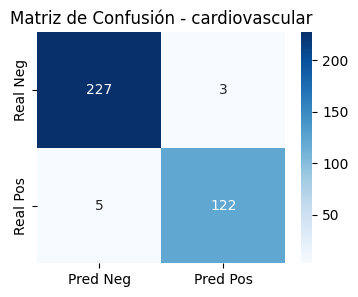


Matriz para la clase: 'hepatorenal'


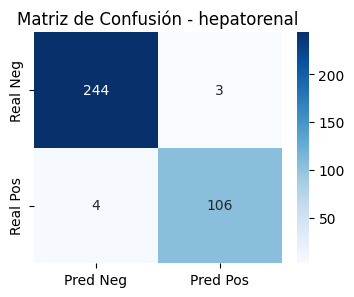


Matriz para la clase: 'neurological'


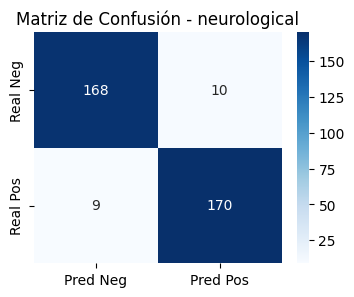


Matriz para la clase: 'oncological'


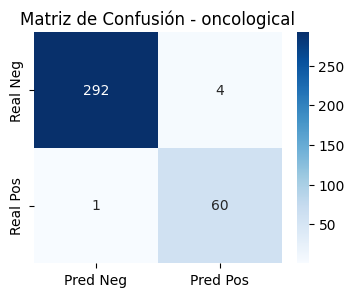


📋 PROMPT LISTO PARA COPIAR EN V0


Crea un dashboard de análisis de resultados para un modelo de IA de clasificación biomédica. El diseño debe ser limpio, moderno y profesional, con un tema oscuro.

El título principal debe ser "Análisis de Rendimiento del Modelo de Clasificación Biomédica".

En la parte superior, quiero una sección de "Métricas Globales" con cuatro tarjetas (KPI cards) bien destacadas:
- Una tarjeta para "F1-Score Ponderado" con el valor 0.959
- Una tarjeta para "Precisión Ponderada" con el valor 0.958
- Una tarjeta para "Recall Ponderado" con el valor 0.960
- Una tarjeta para "Exactitud de Subconjunto" con el valor 0.902

Debajo, en una sección titulada "Rendimiento por Categoría", muestra una tabla con los siguientes datos. Las columnas deben ser "Categoría", "Precisión", "Recall", "F1-Score" y "Soporte":
- Fila 1: cardiovascular, 0.976, 0.961, 0.968, 127.0
- Fila 2: hepatorenal, 0.972, 0.964, 0.968, 110.0
- Fila 3: neurological, 0.944, 0.950, 0.947, 179.0
- Fila 4

In [ ]:
# --- 1. Importaciones ---
import pandas as pd
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    multilabel_confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Definición de la Función Principal ---
def calculate_metrics_from_file(csv_path: str):
    """
    Calcula un conjunto completo de métricas para un problema de clasificación multi-etiqueta
    a partir de un archivo CSV con columnas de etiquetas binarias.
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta '{csv_path}'")
        return None

    true_label_cols = ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']
    pred_label_cols = [f'{col}_pred' for col in true_label_cols]

    if not all(col in df.columns for col in true_label_cols + pred_label_cols):
        print("Error: El archivo CSV no contiene las columnas de etiquetas esperadas.")
        return None

    y_true = df[true_label_cols].values
    y_pred = df[pred_label_cols].values
    
    # Cálculo de Métricas
    metrics = {
        "weighted_f1_score": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "subset_accuracy": accuracy_score(y_true, y_pred),
        "classification_report": classification_report(
            y_true, y_pred, target_names=true_label_cols, output_dict=True, zero_division=0
        ),
        "multilabel_confusion_matrix": multilabel_confusion_matrix(y_true, y_pred),
        "labels": true_label_cols
    }
    
    return metrics

# --- 3. Ejecución y Visualización de Resultados ---
# Asegúrate de que esta ruta sea la correcta para tu archivo
file_path = "data\processed\test_predictions_with_optimal_thresholds.csv"
results = calculate_metrics_from_file(file_path)

if results:
    print("--- METRICAS GLOBALES (PONDERADAS) ---")
    print(f"✅ F1-Score Ponderado: {results['weighted_f1_score']:.4f}")
    print(f"🎯 Precisión Ponderada: {results['weighted_precision']:.4f}")
    print(f"📈 Recall Ponderado: {results['weighted_recall']:.4f}")
    print(f"💯 Exactitud (Subset Accuracy): {results['subset_accuracy']:.4f}\n")

    print("--- REPORTE POR CLASE ---")
    report_df = pd.DataFrame(results['classification_report']).transpose()
    # En un notebook, display es mejor. Si es un script .py, usa print.
    try:
        display(report_df)
    except NameError:
        print(report_df)
    print("\n")

    print("--- MATRIZ DE CONFUSIÓN MULTI-ETIQUETA ---")
    for i, label in enumerate(results['labels']):
        print(f"\nMatriz para la clase: '{label}'")
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.heatmap(results['multilabel_confusion_matrix'][i], annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Real Neg', 'Real Pos'])
        plt.title(f"Matriz de Confusión - {label}")
        plt.show()

    # --- 4. Generación de Prompt para V0 ---
    print("\n" + "="*50)
    print("📋 PROMPT LISTO PARA COPIAR EN V0")
    print("="*50 + "\n")

    # Extraer datos para el prompt de forma más limpia
    cr = results['classification_report']
    mcm = results['multilabel_confusion_matrix']
    labels = results['labels']

    # Crear el texto del prompt usando un f-string de varias líneas
    v0_prompt = f"""
Crea un dashboard de análisis de resultados para un modelo de IA de clasificación biomédica. El diseño debe ser limpio, moderno y profesional, con un tema oscuro.

El título principal debe ser "Análisis de Rendimiento del Modelo de Clasificación Biomédica".

En la parte superior, quiero una sección de "Métricas Globales" con cuatro tarjetas (KPI cards) bien destacadas:
- Una tarjeta para "F1-Score Ponderado" con el valor {results['weighted_f1_score']:.3f}
- Una tarjeta para "Precisión Ponderada" con el valor {results['weighted_precision']:.3f}
- Una tarjeta para "Recall Ponderado" con el valor {results['weighted_recall']:.3f}
- Una tarjeta para "Exactitud de Subconjunto" con el valor {results['subset_accuracy']:.3f}

Debajo, en una sección titulada "Rendimiento por Categoría", muestra una tabla con los siguientes datos. Las columnas deben ser "Categoría", "Precisión", "Recall", "F1-Score" y "Soporte":
- Fila 1: {labels[0]}, {cr[labels[0]]['precision']:.3f}, {cr[labels[0]]['recall']:.3f}, {cr[labels[0]]['f1-score']:.3f}, {cr[labels[0]]['support']}
- Fila 2: {labels[1]}, {cr[labels[1]]['precision']:.3f}, {cr[labels[1]]['recall']:.3f}, {cr[labels[1]]['f1-score']:.3f}, {cr[labels[1]]['support']}
- Fila 3: {labels[2]}, {cr[labels[2]]['precision']:.3f}, {cr[labels[2]]['recall']:.3f}, {cr[labels[2]]['f1-score']:.3f}, {cr[labels[2]]['support']}
- Fila 4: {labels[3]}, {cr[labels[3]]['precision']:.3f}, {cr[labels[3]]['recall']:.3f}, {cr[labels[3]]['f1-score']:.3f}, {cr[labels[3]]['support']}

Finalmente, en la parte inferior, crea una sección llamada "Matrices de Confusión". Muestra cuatro cuadrículas de 2x2, una para cada categoría, con los siguientes valores (TN, FP, FN, TP):
- Matriz para {labels[0]}: {list(mcm[0].ravel())}
- Matriz para {labels[1]}: {list(mcm[1].ravel())}
- Matriz para {labels[2]}: {list(mcm[2].ravel())}
- Matriz para {labels[3]}: {list(mcm[3].ravel())}
"""
    print(v0_prompt)

In [8]:
pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^
